In [45]:
import os, re, math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Simple plot configuration
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

# Define the folder structure
model_evaluation_results_folder_name = "Model Evaluation Results"
model_evaluation_results_folders = {
    "BERT": ["Hyperparameter-1", "Hyperparameter-2", "Hyperparameter-3", "Hyperparameter-4"],
    "DistilBERT": ["Hyperparameter-1", "Hyperparameter-2", "Hyperparameter-3", "Hyperparameter-4"]
}


BERT Model



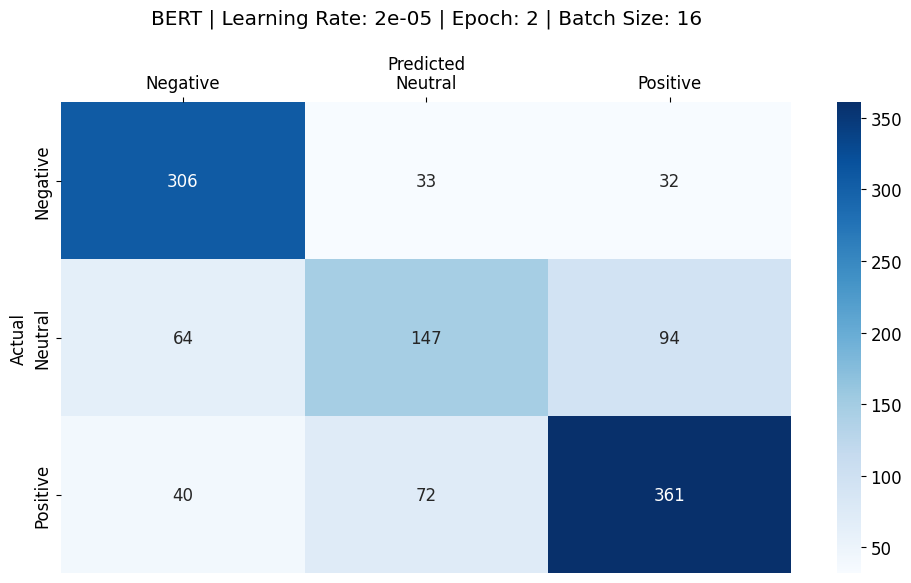

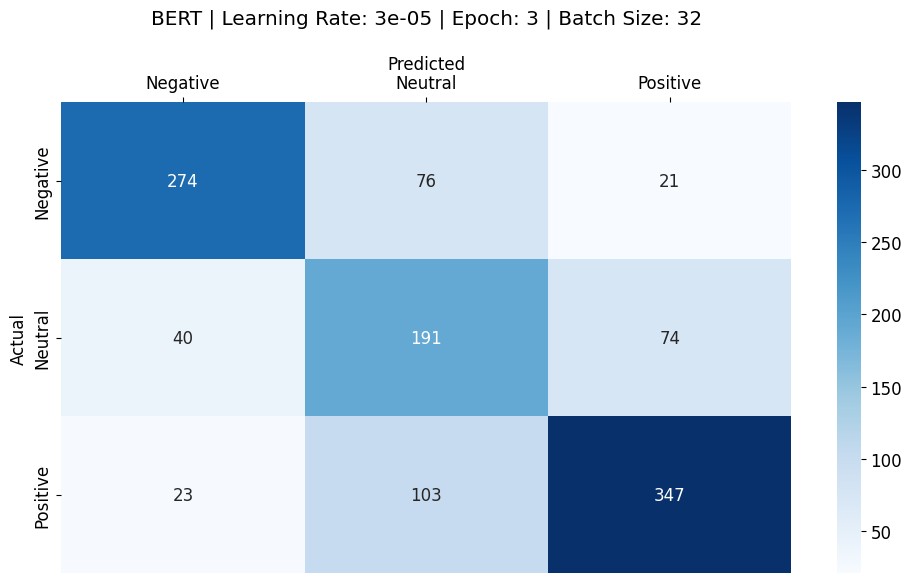

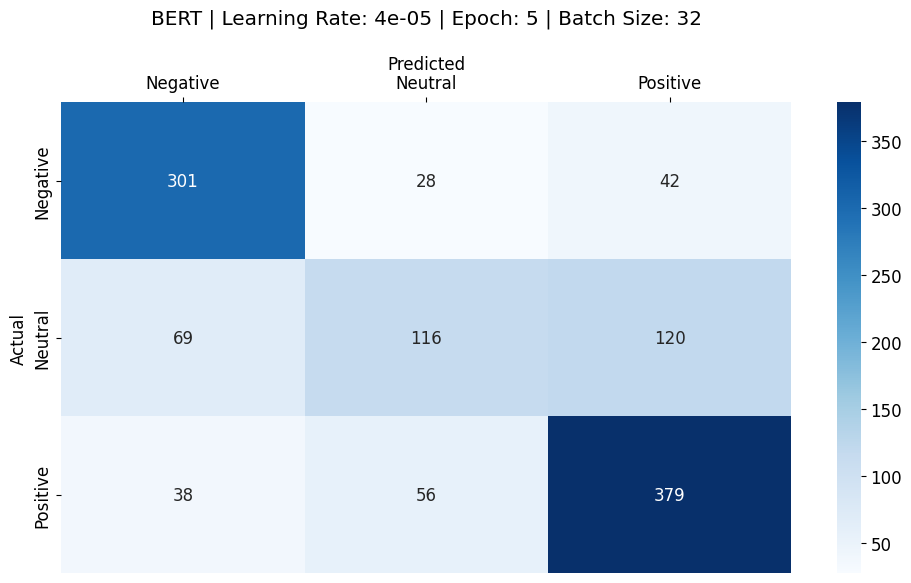

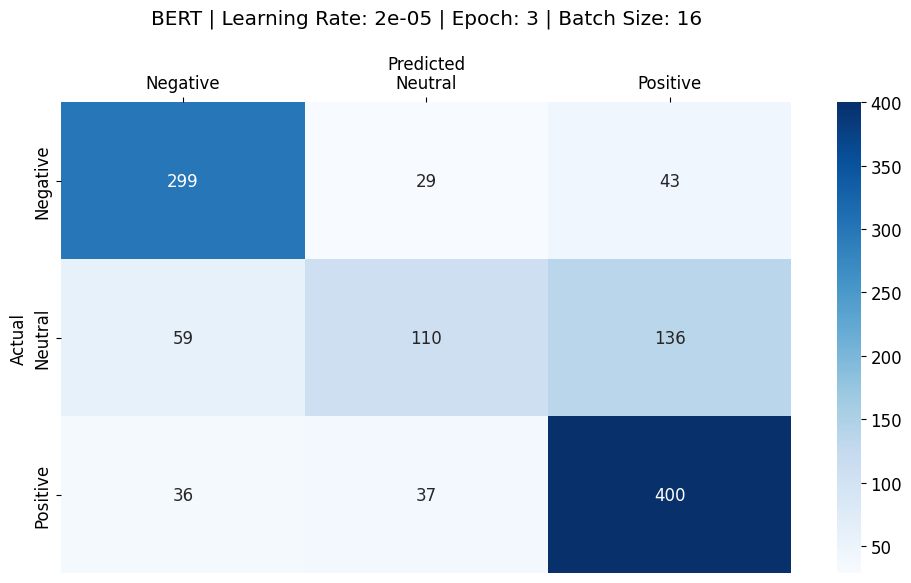


DistilBERT Model



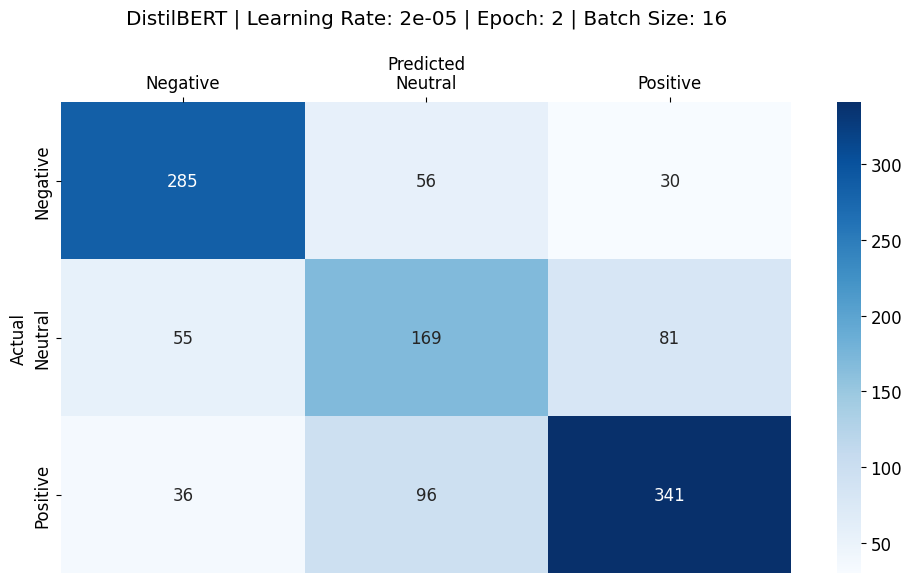

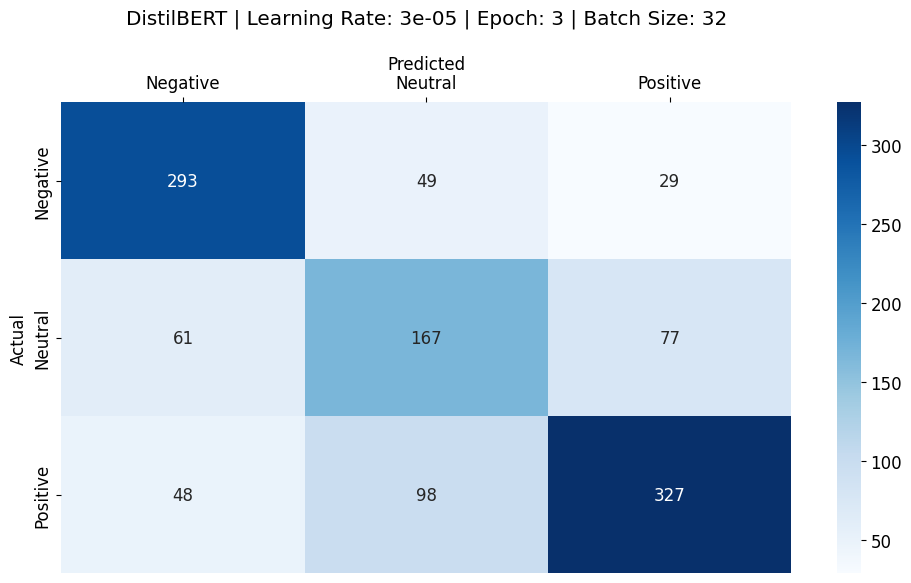

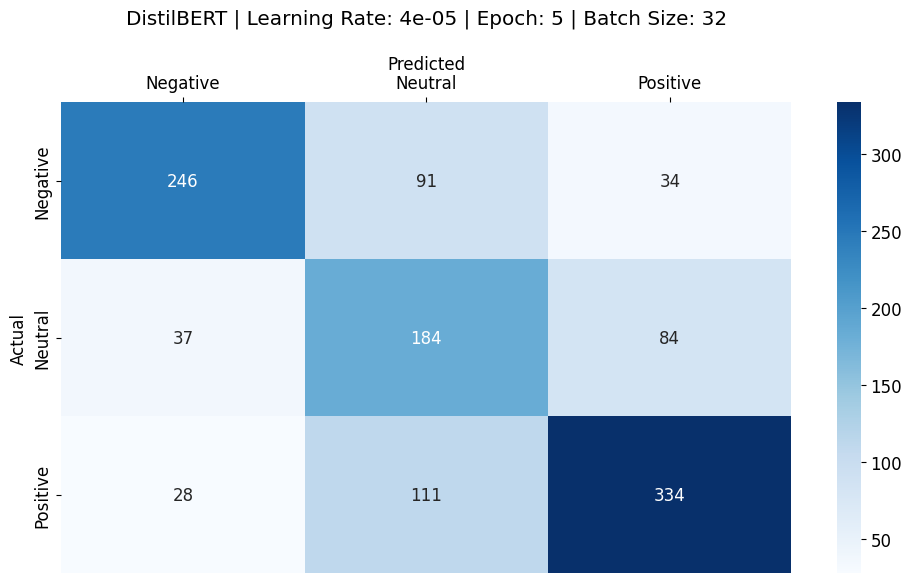

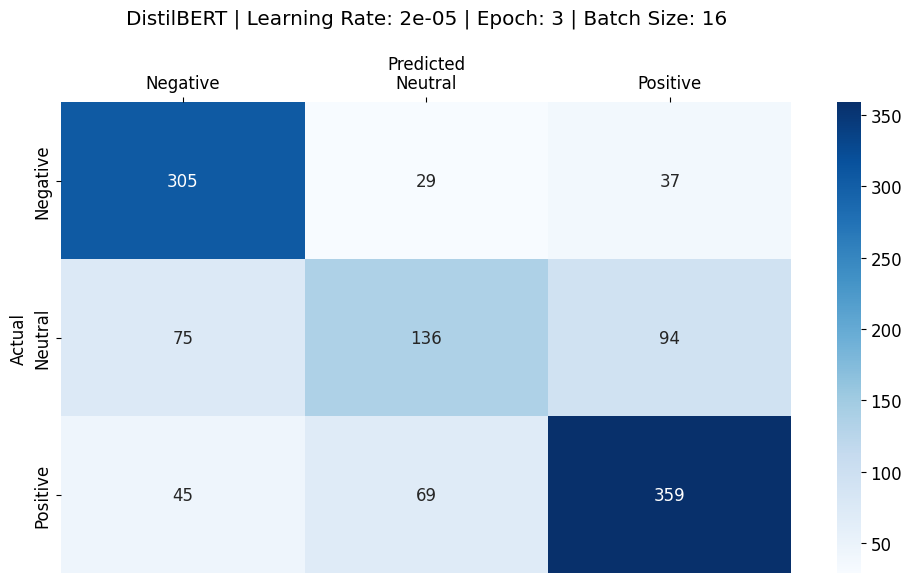

In [61]:
def create_confusion_matrix(y_true, y_pred, title):
    # Define mapping of class labels to words
    class_labels = [-1, 0, 1]  # Class labels for confusion matrix
    class_names = ["Negative", "Neutral", "Positive"]  # Class names corresponding to the labels
    
    # Create confusion matrix with defined labels
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    
    # Create figure for the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot raw counts with correct labels (annot=True to show numbers inside heatmap cells)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    
    # Set title and axis labels
    ax.set_title(f'{title}\n')
    ax.set_xlabel('Predicted')  # X-axis represents predicted classes
    ax.set_ylabel('Actual')    # Y-axis represents true classes
    
    # Move x-axis label and ticks to the top
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    
    # Adjust layout to ensure everything fits well
    plt.tight_layout()
    
    # Display the plot
    plt.show()
def show_model_confusion_matrices():
    for model_folder in model_evaluation_results_folders:
        
        print(f"\n{model_folder} Model\n")
        
        for hyperparameter_folder in model_evaluation_results_folders[model_folder]:
            folder_path = os.path.join(
                model_evaluation_results_folder_name,
                model_folder,
                hyperparameter_folder
            )
            
            # Find prediction files
            unique_file_suffix = " - Predicted Dataset.csv"
            prediction_files = [f for f in os.listdir(folder_path) if f.endswith(unique_file_suffix)]

            if len(prediction_files) == 0:
                raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{folder_path}"')
            elif len(prediction_files) > 1:
                raise Exception(f'File with "{unique_file_suffix}" suffix in "{folder_path}" is duplicated')
                
            # Get the prediction file
            file = prediction_files[0]
            file_path = os.path.join(folder_path, file)
            
            # Load data
            df = pd.read_csv(file_path)
            y_true, y_pred = df["Final_Sent"], df["Predicted_Sent"]
            
            # Create visualization
            params_short = file.replace(unique_file_suffix, "").split(", ")
            params_short = [
                param.replace("LR ", "Learning Rate: ")
                     .replace("E ", "Epoch: ")
                     .replace("BS ", "Batch Size: ")
                for param in params_short
            ]
            params_short.insert(0, model_folder)
            title = " | ".join(params_short)
            create_confusion_matrix(y_true, y_pred, title)

show_model_confusion_matrices()


BERT Model



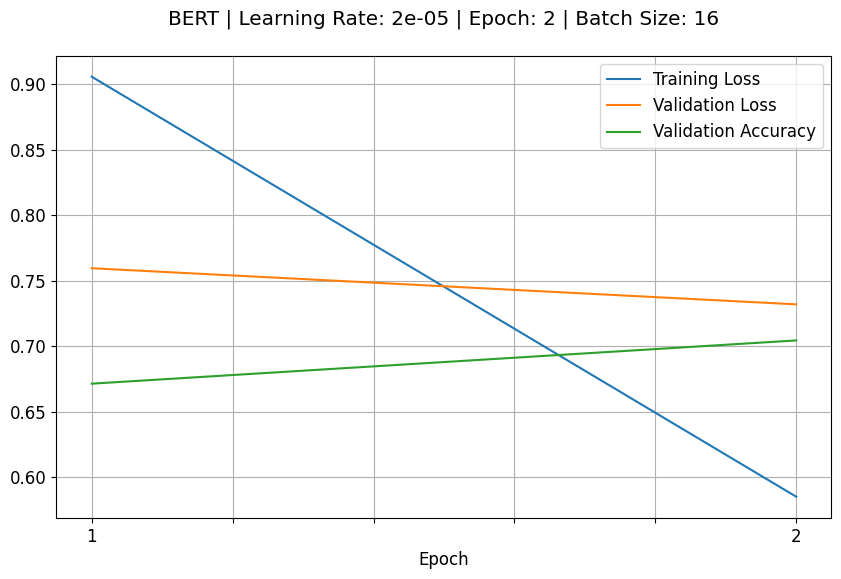

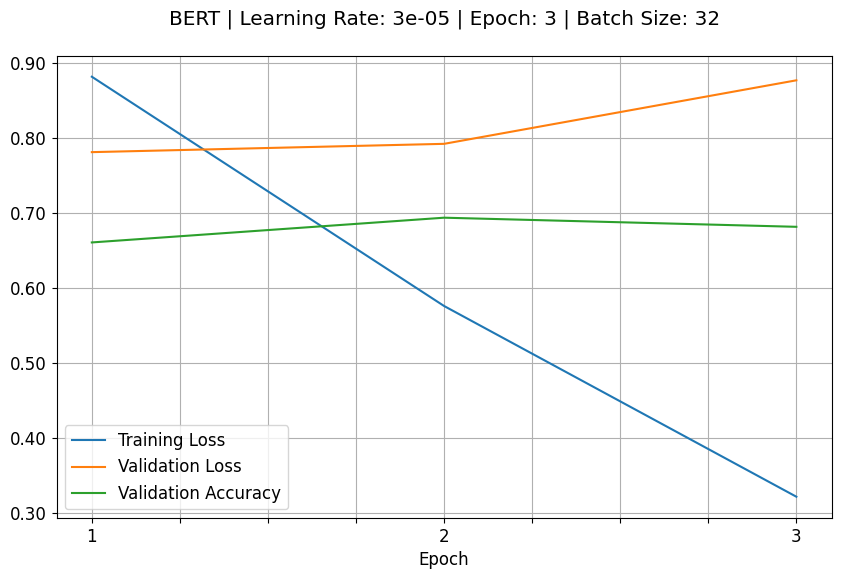

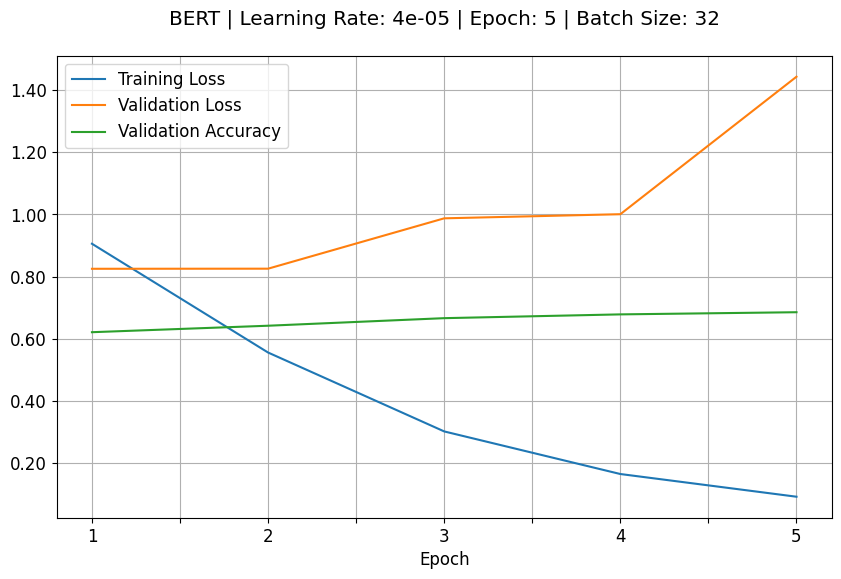

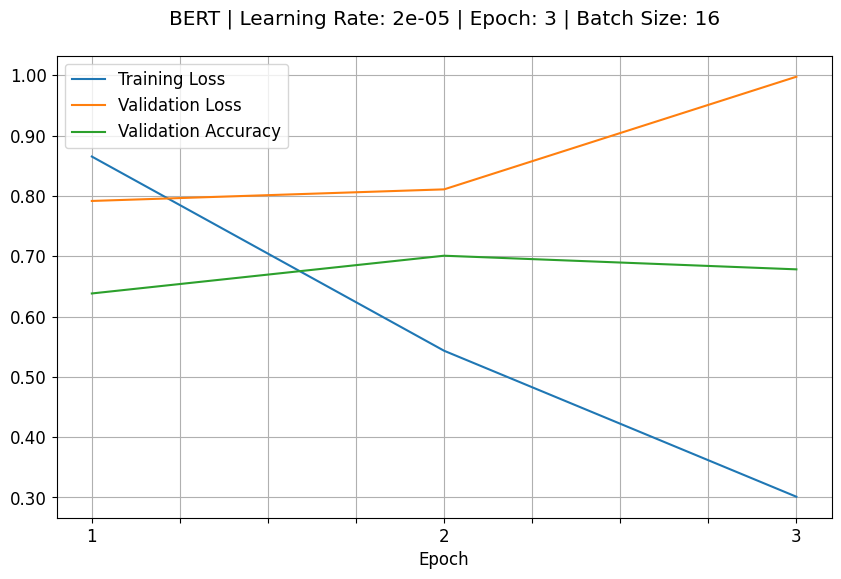


DistilBERT Model



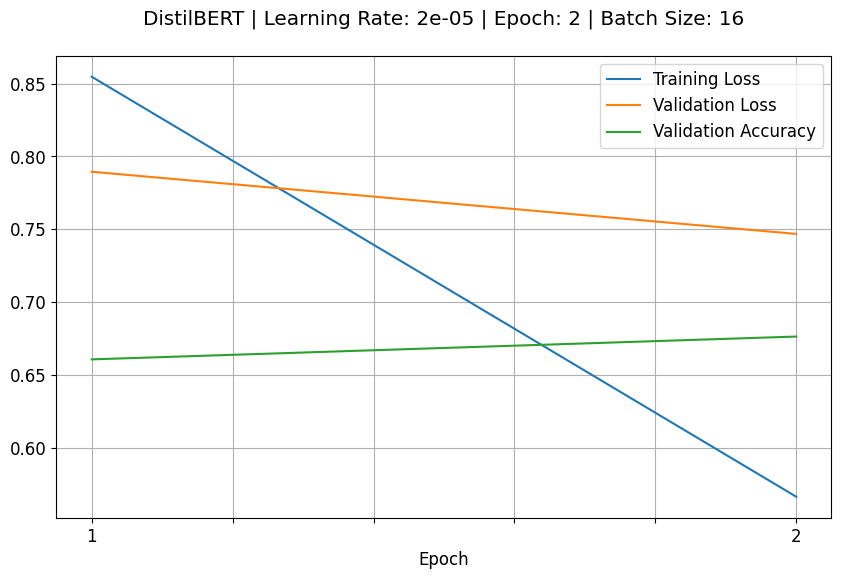

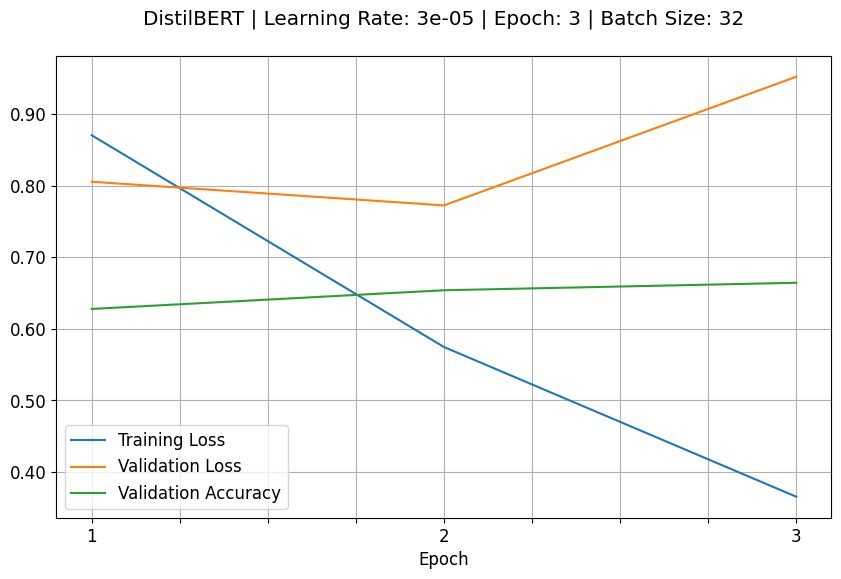

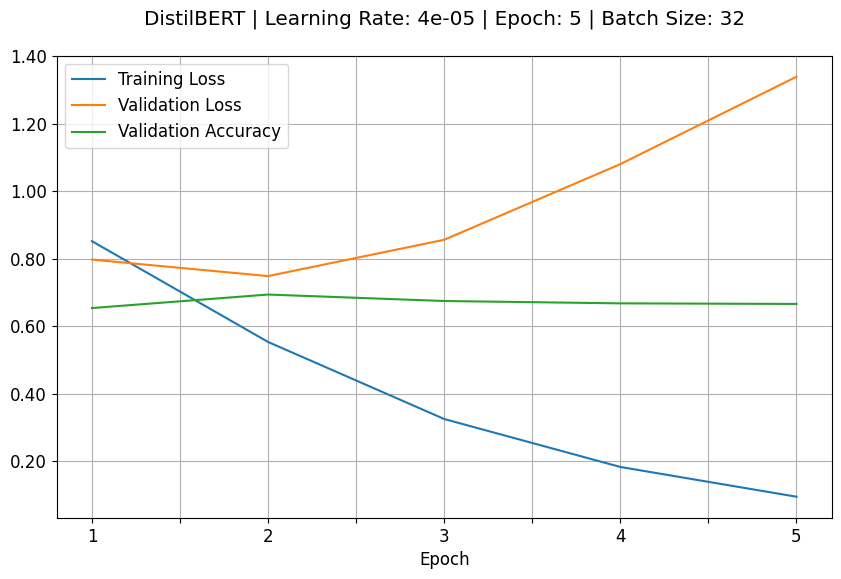

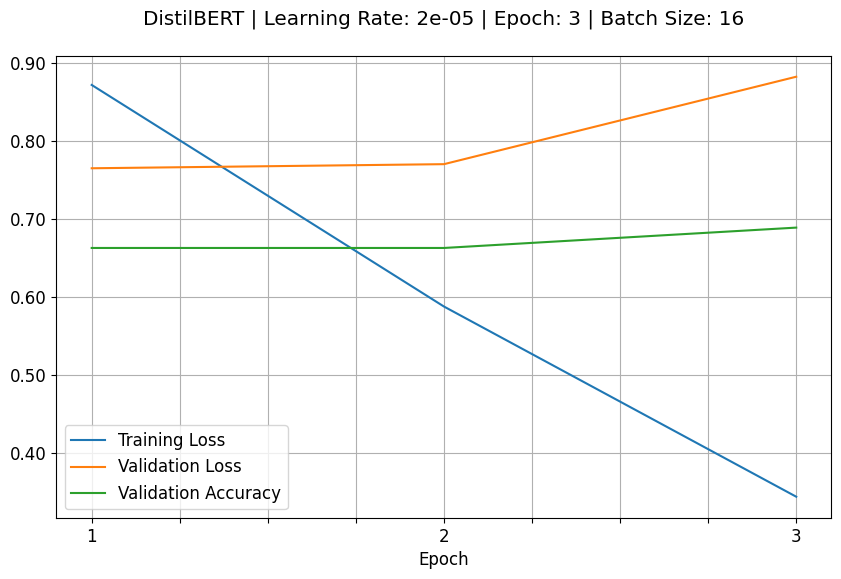

In [63]:
def create_validation_line_graph(val_metric_seq, title):
    # Create a figure with specified size
    plt.figure(figsize=(10, 6))
    
    # Loop through the validation metrics and plot each metric
    for key, val in val_metric_seq.items():
        plt.plot(range(1, len(val) + 1), val, label=key)  # Plot each metric for every epoch

    # Set title for the plot
    plt.title(f'{title}\n')
    
    # Format x-ticks to show integer values only (without decimals)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}' if x.is_integer() else ''))

    # Format y-ticks to show only 2 decimal points
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
        lambda tick, pos: f"{tick:.2f}" if math.isclose(tick, math.floor(tick * 100) / 100) else ""
    ))
    
    # Set the x-axis label and grid
    plt.xlabel('Epoch')
    plt.legend()  # Add legend to the plot
    plt.grid(True)  # Display grid for better visibility of the lines
    
    # Display the plot
    plt.show()
    
def show_model_validation_metrics():
    for model_folder in model_evaluation_results_folders:
        
        print(f"\n{model_folder} Model\n")
        
        for hyperparameter_folder in model_evaluation_results_folders[model_folder]:
            folder_path = os.path.join(
                model_evaluation_results_folder_name,
                model_folder,
                hyperparameter_folder
            )
            
            # Find prediction files
            unique_file_suffix = " - Validation Metric.csv"
            prediction_files = [f for f in os.listdir(folder_path) if f.endswith(unique_file_suffix)]
            
            if len(prediction_files) == 0:
                raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{folder_path}"')
            elif len(prediction_files) > 1:
                raise Exception(f'File with "{unique_file_suffix}" suffix in "{folder_path}" is duplicated')
                
            # Get the prediction file
            file = prediction_files[0]
            file_path = os.path.join(folder_path, file)
                
            # Load data
            df = pd.read_csv(file_path)
            val_metric_seq = df.to_dict(orient='list')
            val_metric_seq = {
                key
                .replace('_', ' ')
                .replace('val ', 'Validation ')
                .replace('train ', 'Training ')
                .title(): value for key, value in val_metric_seq.items()
            }
            
            # Create visualization
            params_short = file.replace(unique_file_suffix, "").split(", ")
            params_short = [
                param.replace("LR ", "Learning Rate: ")
                     .replace("E ", "Epoch: ")
                     .replace("BS ", "Batch Size: ")
                for param in params_short
            ]
            params_short.insert(0, model_folder)
            title = " | ".join(params_short)
            create_validation_line_graph(val_metric_seq, title)

show_model_validation_metrics()


BERT Model



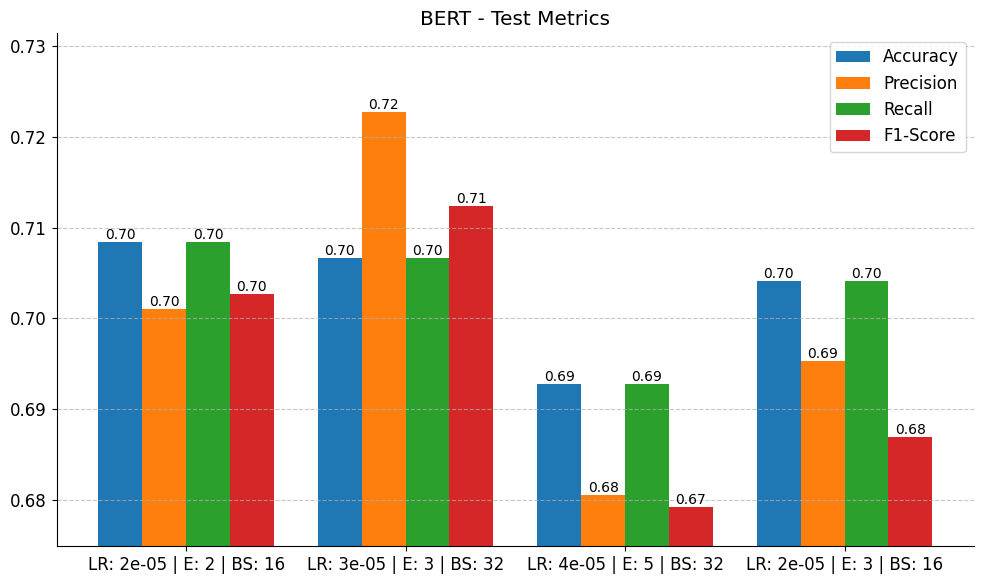


DistilBERT Model



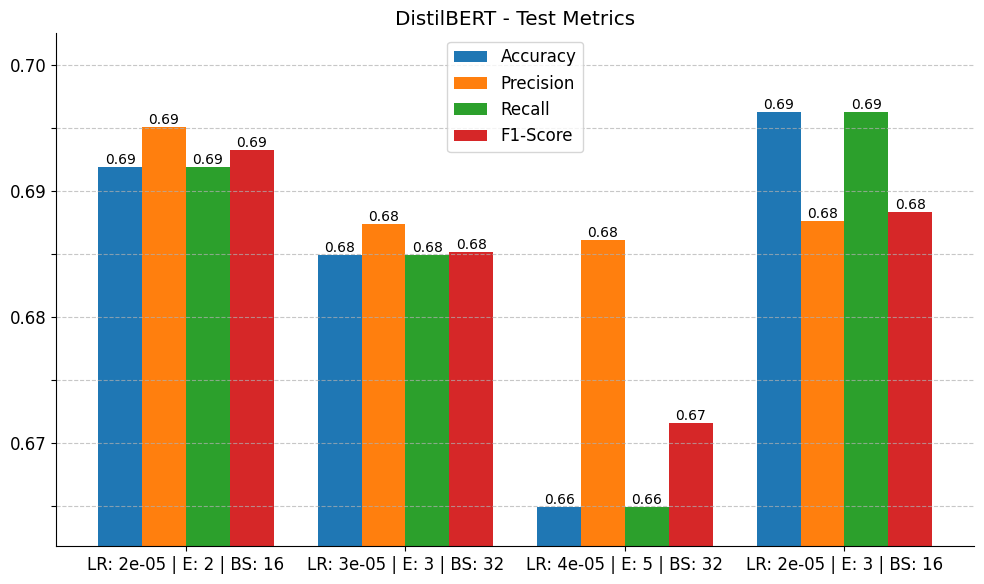

In [62]:
def plot_test_metrics(model_test_metrics, model_parameters, title):
    plt.figure(figsize=(10, 6))

    n_model_parameters = len(model_parameters)
    model_test_metric_names = [model_test_metric_name for model_test_metric_name in model_test_metrics]
    n_model_test_metric_names = len(model_test_metric_names)
    
    total_width = 0.8  # Total width allotted for each group of bars
    width = total_width / n_model_test_metric_names  # Width of each individual bar
    
    # Compute offsets for each bar so that the centers line up at the group position.
    # For even number of bars, np.linspace will produce symmetric offsets.
    offsets = np.linspace(-total_width/2 + width/2, total_width/2 - width/2, n_model_test_metric_names)
    
    # Group positions where each group's center should be
    group_positions = np.arange(n_model_parameters)

    # Initialize min and max y-values
    y_min = float('inf')  # Start with a very high value
    y_max = float('-inf') # Start with a very low value
    for idx, model_test_metric_name in enumerate(model_test_metric_names):
        # Get the bar heights
        bar_heights = model_test_metrics[model_test_metric_name]
        # Update min and max y-values
        y_min = min(y_min, min(bar_heights))
        y_max = max(y_max, max(bar_heights))
        # Calculate new x positions using the computed offset.
        x = group_positions + offsets[idx]
        # Use align='center' so that the x value is interpreted as the center of the bar.
        bars = plt.bar(x, bar_heights, width=width, label=model_test_metric_name, align='center')
        # Add text labels above the bars
        for bar in bars:
            height = bar.get_height()
            height_str = str(height)[:str(height).find('.') + 3] if '.' in str(height) else str(height)  # Keep up to 2 decimal places
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
                bar.get_height(),                   # Y position (top of bar)
                height_str,          # Label text (formatted to 2 decimal places)
                ha='center', va='bottom',           # Center horizontally, place slightly above
                fontsize=10, color='black'          # Styling options
            )
            
    # Set x-tick positions at the center of each group.
    plt.xticks(group_positions, model_parameters)
    
    plt.title(title)
    plt.legend()
    
    # Remove top/right spines and add gridlines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Set a minimum highest point for the y-axis
    y_values_range = (y_max - y_min)
    plt.ylim(y_min - (y_values_range * 0.1), y_max + (y_values_range * 0.2))

    # Format y-ticks to show only 2 decimal points
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
        lambda tick, pos: f"{tick:.2f}" if math.isclose(tick, math.floor(tick * 100) / 100) else ""
    ))

    plt.tight_layout()
    plt.show()

def show_model_test_metrics():
    for model_folder in model_evaluation_results_folders:
        
        print(f"\n{model_folder} Model\n")

        model_test_metric_names = ['Accuracy',  'Precision', 'Recall', 'F1-Score']
        model_parameters = []
        model_test_metrics = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': []
        }
        
        for hyperparameter_folder in model_evaluation_results_folders[model_folder]:
            folder_path = os.path.join(
                model_evaluation_results_folder_name,
                model_folder,
                hyperparameter_folder
            )
            
            # Find prediction files
            unique_file_suffix = " - Test Metric.csv"
            prediction_files = [f for f in os.listdir(folder_path) if f.endswith(unique_file_suffix)]
            
            if len(prediction_files) == 0:
                raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{folder_path}"')
            elif len(prediction_files) > 1:
                raise Exception(f'File with "{unique_file_suffix}" suffix in "{folder_path}" is duplicated')
                
            # Get the prediction file
            file = prediction_files[0]
            file_path = os.path.join(folder_path, file)
                
            # Load data
            df = pd.read_csv(file_path)
            test_metrics = df.iloc[0].to_dict()
            test_metrics = {
                key.title(): value for key, value in test_metrics.items()
            }
            
            # Get and Edit Parameter Name
            params_short = file.replace(unique_file_suffix, "").split(", ")
            params_short = [
                param.replace("LR ", "LR: ")
                     .replace("E ", "E: ")
                     .replace("BS ", "BS: ")
                for param in params_short
            ]
            parameter_name = " | ".join(params_short)

            # Create parameter item with its test metrics
            for metric in model_test_metrics:
                if test_metrics[metric] is None:
                    raise Exception(f'Missing Test Metric "{metric}" in "{file_path}"')
                else:
                    model_test_metrics[metric].append(test_metrics[metric])
                    
            model_parameters.append(parameter_name)

        # Create visualization
        plot_test_metrics(model_test_metrics, model_parameters, f'{model_folder} - Test Metrics')


show_model_test_metrics()

In [84]:
def create_confusion_matrix(y_true, y_pred, title):
    # Define mapping of class labels to words
    class_labels = [-1, 0, 1]  # Class labels for confusion matrix
    class_names = ["Negative", "Neutral", "Positive"]  # Class names corresponding to the labels
    
    # Create confusion matrix with defined labels
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    
    # Create figure for the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot raw counts with correct labels (annot=True to show numbers inside heatmap cells)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    
    # Set title and axis labels
    ax.set_title(f'{title}\n')
    ax.set_xlabel('Predicted')  # X-axis represents predicted classes
    ax.set_ylabel('Actual')    # Y-axis represents true classes
    
    # Move x-axis label and ticks to the top
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    
    # Adjust layout to ensure everything fits well
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
def calculate_sentiment_shares(df, group_name, target_name):
    # Calculate metrics for each candidate
    results = []
    
    for group in df[group_name].unique():
        # Get sentiment scores for the candidate
        scores = df[df[group_name] == group][target_name].values
        
        # Calculate average sentiment
        avg_sentiment = np.mean(scores)
        
        # Calculate s score (average of max and min values)
        s_score = (max(avg_sentiment, 0) + 1) / 2
        
        results.append({
            group_name: group,
            'Average_Sentiment': avg_sentiment,
            'S_Score': s_score
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate relative shares
    total_s_score = results_df['S_Score'].sum()
    results_df['Share_Percentage'] = (results_df['S_Score'] / total_s_score) * 100
    
    return results_df
    
def show_model_confusion_matrices():
    # Check best model accuracy and get the predicted dataset
    best_model_folder_path = None
    best_model_accuracy = None
    for model_folder in model_evaluation_results_folders:
        
        print(f"\n{model_folder} Model\n")

        model_test_metric_names = ['Accuracy',  'Precision', 'Recall', 'F1-Score']
        model_parameters = []
        model_test_metrics = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': []
        }
        
        for hyperparameter_folder in model_evaluation_results_folders[model_folder]:
            folder_path = os.path.join(
                model_evaluation_results_folder_name,
                model_folder,
                hyperparameter_folder
            )
            
            # Find prediction files
            unique_file_suffix = " - Test Metric.csv"
            prediction_files = [f for f in os.listdir(folder_path) if f.endswith(unique_file_suffix)]
            
            if len(prediction_files) == 0:
                raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{folder_path}"')
            elif len(prediction_files) > 1:
                raise Exception(f'File with "{unique_file_suffix}" suffix in "{folder_path}" is duplicated')
                
            # Get the prediction file
            file = prediction_files[0]
            file_path = os.path.join(folder_path, file)
                
            # Load data
            df = pd.read_csv(file_path)
            test_metrics = df.iloc[0].to_dict()

            # Get accuracy
            accuracy = test_metrics['accuracy']
            if accuracy is None:
                raise Exception(f'Missing Test Metric "accuracy" in "{file_path}"')
            
            if best_model_accuracy is None or accuracy > best_model_accuracy:
                best_model_accuracy = accuracy
                best_model_folder_path = folder_path

    # Get predicted test dataset of best model
    unique_file_suffix = " - Predicted Dataset.csv"
    prediction_files = [f for f in os.listdir(best_model_folder_path) if f.endswith(unique_file_suffix)]
    
    if len(prediction_files) == 0:
        raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{best_model_folder_path}"')
    elif len(prediction_files) > 1:
        raise Exception(f'File with "{unique_file_suffix}" suffix in "{best_model_folder_path}" is duplicated')
        
    # Get the prediction file
    print(file)
    file = prediction_files[0]
    file_path = os.path.join(best_model_folder_path, file)
        
    # Load data
    df = pd.read_csv(file_path)
    all_results = []
    
    for state in df['State'].unique():
        # Get data for the current state
        state_df = df[df['State'] == state]
        
        # Calculate sentiment shares for this state
        state_results = calculate_sentiment_shares(
            state_df, 
            'Presidential_Candidate', 
            'Predicted_Sent'
        )
        
        # Add state column to results
        state_results['State'] = state
        
        all_results.append(state_results)
    
    # Combine results from all states
    final_results = pd.concat(all_results, ignore_index=True)
    
    # Reorder columns to put State first
    cols = ['State'] + [col for col in final_results.columns if col != 'State']
    final_results = final_results[cols]
    
    return final_results
    

show_model_confusion_matrices()


BERT Model


DistilBERT Model

LR 2e-05, E 3, BS 16 - Test Metric.csv


,State,Presidential_Candidate,Average_Sentiment,S_Score,Share_Percentage
0,Pennsylvania,Kamala Harris,0.037267,0.518634,50.914634
1,Pennsylvania,Donald Trump,0.000000,0.500000,49.085366
2,Arizona,Kamala Harris,0.168269,0.584135,53.880266
3,Arizona,Donald Trump,-0.074419,0.500000,46.119734
4,Michigan,Kamala Harris,0.129353,0.564677,50.000000
5,Michigan,Donald Trump,0.129353,0.564677,50.000000


In [83]:
50.914634 + 49.085366, 53.880266 + 46.119734, 50.000000 + 50.000000

(100.0, 100.0, 100.0)